In [539]:
# import packages for linear algebra and dataframes
import numpy as np
import pandas as pd

# import packages for algorithms
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# import packages for data visualization
import seaborn as sns

# from matplotlib import style
%matplotlib inline

In [540]:
# load ec2 dataset containing data collected over consecutive 30 days
spot = pd.read_csv("/Users/Chee San/Downloads/train_ec2_10f2c.csv")

In [541]:
# Get an overview of the dataset
spot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14256 entries, 0 to 14255
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             14256 non-null  int64  
 1   check_time                     14256 non-null  object 
 2   instance_type                  14256 non-null  object 
 3   vcpus                          14256 non-null  int64  
 4   sustained_clock_speed_ghz      14256 non-null  float64
 5   memory_mib                     14256 non-null  int64  
 6   gpus                           14256 non-null  int64  
 7   on_demand_hibernation_support  14256 non-null  bool   
 8   burstable_performance_support  14256 non-null  bool   
 9   current_generation             14256 non-null  bool   
 10  interruption_rate              14256 non-null  object 
dtypes: bool(3), float64(1), int64(4), object(3)
memory usage: 932.9+ KB


In [542]:
# Removed the columns which are not going to be used as predictors
spot = spot.drop(columns=['id'])
spot = spot.drop(columns=['check_time'])
spot = spot.drop(columns=['instance_type'])

# View the first 10 rows of the dataset
spot.head(10)

,vcpus,sustained_clock_speed_ghz,memory_mib,gpus,on_demand_hibernation_support,burstable_performance_support,current_generation,interruption_rate
0,2,2.3,4096,0,True,True,True,unlikely
1,1,2.5,1024,0,True,True,True,unlikely
2,1,2.5,2048,0,True,True,True,unlikely
3,4,2.3,16384,0,True,True,True,unlikely
4,16,2.3,32768,0,False,False,True,unlikely
5,96,3.6,196608,0,False,False,True,unlikely
6,96,3.6,196608,0,False,False,True,unlikely
7,72,3.4,196608,0,False,False,True,unlikely
8,72,3.4,196608,0,False,False,True,unlikely
9,16,2.9,30720,0,True,False,True,unlikely


In [543]:
# Normalize numerical columns
mms = preprocessing.MinMaxScaler()
spot[['vcpus','sustained_clock_speed_ghz','memory_mib','gpus']] = mms.fit_transform(spot[['vcpus','sustained_clock_speed_ghz',
                                                                                          'memory_mib','gpus']])

# Convert interruption_rate into '1' for 'likely' and '0' for 'unlikely'
category = {'likely': 1, 'unlikely': 0}
spot.interruption_rate = [category[item] for item in spot.interruption_rate]

In [544]:
# Encoding the nominal values and passthrough other columns
spot_features = spot[['vcpus', 'sustained_clock_speed_ghz', 'memory_mib', 
                 'gpus', 'on_demand_hibernation_support', 'burstable_performance_support', 
                 'current_generation']]

# convert nominal to binary
one_hot_encoded_training_predictors = pd.get_dummies(spot_features)

#spot.head(3)
#print(one_hot_encoded_training_predictors.head(10))

In [545]:
X = one_hot_encoded_training_predictors # Features
y = spot['interruption_rate'] # Target variable
one_hot_encoded_training_predictors.to_csv("/Users/Chee San/Downloads/spot_transformed.csv")

In [546]:
# Logistic Regression
logreg = LogisticRegression(solver = 'lbfgs', max_iter = 1000)
scores_lgr = cross_val_score(logreg, X, y, cv=10, scoring = 'accuracy')
mean_lgr = round((scores_lgr.mean()*100),2)
std_lgr = round((scores_lgr.std()*100),2)
print('Logistic Regression accuracy =', mean_lgr, u"\u00B1", std_lgr)

Logistic Regression accuracy = 71.37 ± 0.93


In [547]:
# Logistic Regression results and confusion matrix
y_pred_lgr = cross_val_predict(logreg, X, y, cv=10)
conf_mat = confusion_matrix(y,y_pred_lgr)
print('Logistic Regression confusion matrix:')
print(conf_mat)

Logistic Regression confusion matrix:
[[3474 3402]
 [ 679 6701]]


In [548]:
# Get classification report of logistic regression
print('Logistic Regression score summary:')
print(classification_report(y,y_pred_lgr))

Logistic Regression score summary:
              precision    recall  f1-score   support

           0       0.84      0.51      0.63      6876
           1       0.66      0.91      0.77      7380

    accuracy                           0.71     14256
   macro avg       0.75      0.71      0.70     14256
weighted avg       0.75      0.71      0.70     14256



In [549]:
# Get ROC score of the logistic regression model
roc_auc_score(y, y_pred_lgr)

0.7066150910200201

In [562]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators = 100)
random_forest.fit(X, y)
scores_random_forest = cross_val_score(random_forest, X, y, cv=10, scoring = 'accuracy')
mean_rf = round((scores_random_forest.mean()*100),2)
std_rf = round((scores_random_forest.std()*100),2)
#acc_random_forest = round(random_forest.score(X, y) * 100, 2)
print('Random Forest accuracy =',mean_rf, u"\u00B1",std_rf)

Random Forest accuracy = 80.93 ± 1.41


In [563]:
# Random forest results and confusion matrix
y_pred_rf = cross_val_predict(random_forest, X, y, cv=10)
conf_mat_rf = confusion_matrix(y, y_pred_rf)
print('Random Forest confusion matrix:')
print(conf_mat_rf)

Random Forest confusion matrix:
[[5628 1248]
 [1475 5905]]


In [565]:
# Get classification report of random forest
print('Random Forest score summary:')
print(classification_report(y, y_pred_rf))

Random Forest score summary:
              precision    recall  f1-score   support

           0       0.79      0.82      0.81      6876
           1       0.83      0.80      0.81      7380

    accuracy                           0.81     14256
   macro avg       0.81      0.81      0.81     14256
weighted avg       0.81      0.81      0.81     14256



In [566]:
# Get ROC score of the random forest model
roc_auc_score(y, y_pred_rf)

0.8093173143773322

In [567]:
# Decision Tree
decision_tree = DecisionTreeClassifier() 
decision_tree.fit(X, y) 
scores_dt = cross_val_score(decision_tree, X, y, cv=10, scoring = 'accuracy')
mean_dt = round((scores_dt.mean()*100),2)
std_dt = round((scores_dt.std()*100),2)
print('Decision Tree accuracy =', mean_dt, u"\u00B1", std_dt)

Decision Tree accuracy = 80.92 ± 1.42


In [568]:
# Decision tree results and confusion matrix
y_pred_dt = cross_val_predict(decision_tree, X, y, cv=10)
conf_mat_dt = confusion_matrix(y, y_pred_dt)
print('Decision Tree confusion matrix:')
print(conf_mat_dt)

Decision Tree confusion matrix:
[[5745 1131]
 [1589 5791]]


In [569]:
# Get classification report of decision tree
print('Decision Tree score summary:')
print(classification_report(y, y_pred_dt))

Decision Tree score summary:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81      6876
           1       0.84      0.78      0.81      7380

    accuracy                           0.81     14256
   macro avg       0.81      0.81      0.81     14256
weighted avg       0.81      0.81      0.81     14256



In [570]:
# Get ROC score of decision tree
roc_auc_score(y, y_pred_dt)

0.8101015905447013

In [571]:
# K Nearest Neighbor
knn = KNeighborsClassifier(n_neighbors = 3) 
knn.fit(X, y) 
scores_knn = cross_val_score(knn, X, y, cv=10, scoring = 'accuracy')
mean_knn = round((scores_knn.mean()*100),2)
std_knn = round((scores_knn.std()*100),2)
print('KNN accuracy =', mean_knn, u"\u00B1", std_knn)

KNN accuracy = 76.93 ± 1.54


In [572]:
# KNN results and confusion matrix
y_pred_knn = cross_val_predict(knn, X, y, cv=10)
conf_mat_knn = confusion_matrix(y, y_pred_knn)
print('KNN confusion matrix:')
print(conf_mat_knn)

KNN confusion matrix:
[[5416 1460]
 [1829 5551]]


In [573]:
# Get classification report of KNN
print('KNN score summary:')
print(classification_report(y, y_pred_knn))

KNN score summary:
              precision    recall  f1-score   support

           0       0.75      0.79      0.77      6876
           1       0.79      0.75      0.77      7380

    accuracy                           0.77     14256
   macro avg       0.77      0.77      0.77     14256
weighted avg       0.77      0.77      0.77     14256



In [574]:
# Get ROC score of KNN
roc_auc_score(y, y_pred_knn)

0.7699176350402248

In [578]:
# Put result of cross validation into table

result = pd.DataFrame({
    'Model' : ['Logistic Regression',
              'Random Forest', 'Decision Tree', 'KNN'],
    'Scores' : [mean_lgr,
                mean_rf, 
                mean_dt,
                mean_knn],
    'std' : [std_lgr,std_rf,std_dt,std_knn]})
result = result.sort_values(by='Scores', ascending=False)

result['Scores (Cross Validated)'] = result['Scores'].map(str) + ' $\pm$ ' + result['std'].map(str)

result.drop(['std','Scores'], axis=1, inplace=True)

result

,Model,Scores (Cross Validated)
1,Random Forest,80.93 $\pm$ 1.41
2,Decision Tree,80.92 $\pm$ 1.42
3,KNN,76.93 $\pm$ 1.54
0,Logistic Regression,71.37 $\pm$ 0.93


In [579]:
# Compute the proportion errors between top 2 algorithms using McNemar test

from statsmodels.stats.contingency_tables import mcnemar
# Define contingency table
table = [[23075, 14259],[14253,5437]]

# Calculate mcnemar test
result = mcnemar(table, exact=True)
# Summarize the finding
print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))
# Interpret the p-value
alpha = 0.05
if result.pvalue > alpha:
	print('Same proportions of errors (fail to reject H0)')
else:
	print('Different proportions of errors (reject H0)')

statistic=14253.000, p-value=0.976
Same proportions of errors (fail to reject H0)


In [581]:
# Decision tree is chosen for hyperparameter tuning because it has lower SD compared to RF

# Perform grid search on decision tree
from sklearn.model_selection import GridSearchCV
dt = DecisionTreeClassifier()
grid = {"criterion":("gini", "entropy"), "splitter":("best", "random"), "min_samples_leaf":[5, 10, 15, 20], 
        "min_samples_split":[2, 3, 4, 5], 'max_leaf_nodes':[250, 450, 350, 550], "max_features":("auto", "log2", "sqrt")}
clf = GridSearchCV(dt, grid, verbose = 1, cv = 10)
clf.fit(X, y)
clf.best_params_

Fitting 10 folds for each of 768 candidates, totalling 7680 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 7680 out of 7680 | elapsed:  1.5min finished


{'criterion': 'entropy',
 'max_features': 'log2',
 'max_leaf_nodes': 350,
 'min_samples_leaf': 10,
 'min_samples_split': 4,
 'splitter': 'random'}

In [585]:
print(clf.best_score_*100)

80.94864299598929


In [586]:
# Decision tree after hyperparameter tuning
decision_tree_ht = DecisionTreeClassifier(criterion = 'entropy', max_features = 'auto', max_leaf_nodes = 350, 
                                          min_samples_leaf = 5, min_samples_split = 3, splitter = 'random') 
decision_tree_ht.fit(X, y) 
scores_dt_ht = cross_val_score(decision_tree_ht, X, y, cv=10, scoring = 'accuracy')
mean_dt_ht = round((scores_dt_ht.mean()*100),2)
std_dt_ht = round((scores_dt_ht.std()*100),2)
print('Decision Tree accuracy after hyperparameter tuning =', mean_dt_ht, u"\u00B1", std_dt_ht)

Decision Tree accuracy after hyperparameter tuning = 80.92 ± 1.42


In [592]:
# Decision tree (tuned) results and confusion matrix
y_pred_dt_ht = cross_val_predict(decision_tree_ht, X, y, cv=10)
conf_mat_dt_ht = confusion_matrix(y, y_pred_dt_ht)
print('Decision tree (tuned) confusion matrix:')
print(conf_mat_dt_ht)

Decision tree (tuned) confusion matrix:
[[5720 1156]
 [1631 5749]]


In [588]:
# Get classification report of decision tree (tuned)
print('Decision tree (tuned) score summary:')
print(classification_report(y, y_pred_dt_ht))

Decision tree (tuned) score summary:
              precision    recall  f1-score   support

           0       0.78      0.83      0.81      6876
           1       0.84      0.78      0.81      7380

    accuracy                           0.81     14256
   macro avg       0.81      0.81      0.81     14256
weighted avg       0.81      0.81      0.81     14256



In [593]:
# Get ROC score of decision tree (tuned)
roc_auc_score(y, y_pred_dt_ht)

0.8054381446955832

In [590]:
# Preform grid search on gradient tree boosting
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
grid = {"n_estimators":[20, 30, 40, 50], "learning_rate":[0.1, 0.3, 0.5]}
clf2 = GridSearchCV(gb, grid, verbose = 1, cv = 10)
clf2.fit(X, y)
clf2.best_params_

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:   23.7s finished


{'learning_rate': 0.5, 'n_estimators': 50}

In [594]:
# Gradient tree boosting after hyperparameter tuning
gb2 = GradientBoostingClassifier(n_estimators = 50, learning_rate = 0.5)
gb2.fit(X, y) 
scores_gb2 = cross_val_score(gb2, X, y, cv=10, scoring = 'accuracy')
mean_gb2 = round((scores_gb2.mean()*100),2)
std_gb2 = round((scores_gb2.std()*100),2)
print('Gradient tree boosting accuracy =', mean_gb2, u"\u00B1", std_gb2)

Gradient tree boosting accuracy = 80.3 ± 1.04


In [595]:
# Get classification report of gradient tree boosting (tuned)
y_pred_gb2 = cross_val_predict(gb2, X, y, cv=10)
conf_mat_gb2 = confusion_matrix(y, y_pred_gb2)
print('Gradient tree boosting confusion matrix:')
print(conf_mat_gb2)

Gradient tree boosting confusion matrix:
[[5415 1461]
 [1348 6032]]


In [596]:
print('Gradient tree boosting (tuned) score summary:')
print(classification_report(y, y_pred_gb2))

Gradient tree boosting (tuned) score summary:
              precision    recall  f1-score   support

           0       0.80      0.79      0.79      6876
           1       0.81      0.82      0.81      7380

    accuracy                           0.80     14256
   macro avg       0.80      0.80      0.80     14256
weighted avg       0.80      0.80      0.80     14256



In [597]:
# Get ROC score of gradient tree boosting (tuned)
roc_auc_score(y, y_pred_gb2)

0.8024329942252302

In [655]:
# load ec2 testing dataset
spot_test = pd.read_csv("/Users/Chee San/Downloads/ec2_testfile.csv")

In [656]:
# Removed the columns which are not going to be used as predictors
spot_test = spot_test.drop(columns=['id'])
spot_test = spot_test.drop(columns=['check_time'])
spot_test = spot_test.drop(columns=['instance_type'])

# View the first 10 rows of the dataset
spot_test.head(10)

,vcpus,sustained_clock_speed_ghz,memory_mib,gpus,on_demand_hibernation_support,burstable_performance_support,current_generation,interruption_rate
0,2,2.3,4096,0,True,True,True,unlikely
1,1,2.5,1024,0,True,True,True,unlikely
2,1,2.5,2048,0,True,True,True,unlikely
3,16,2.3,32768,0,False,False,True,unlikely
4,96,3.6,196608,0,False,False,True,unlikely
5,96,3.6,196608,0,False,False,True,unlikely
6,72,3.4,196608,0,False,False,True,unlikely
7,72,3.4,196608,0,False,False,True,unlikely
8,16,2.9,30720,0,True,False,True,unlikely
9,16,2.9,30720,0,True,False,True,unlikely


In [657]:
# Normalize numerical columns in the testing set
mms = preprocessing.MinMaxScaler()
spot_test[['vcpus','sustained_clock_speed_ghz','memory_mib','gpus']] = mms.fit_transform(spot_test[['vcpus',
                                                                                                    'sustained_clock_speed_ghz','memory_mib','gpus']])

# Convert interruption_rate into '1' for 'likely' and '0' for 'unlikely'
category = {'likely': 1, 'unlikely': 0}
spot_test.interruption_rate = [category[item] for item in spot_test.interruption_rate]

In [658]:
# Encoding the nominal values and passthrough other columns
spot_test_features = spot_test[['vcpus', 'sustained_clock_speed_ghz', 'memory_mib', 
                 'gpus', 'on_demand_hibernation_support', 'burstable_performance_support', 
                 'current_generation']]

# Convert nominal to binary
training_predictors_test = pd.get_dummies(spot_test_features)

In [659]:
# Identify features and target variables
X_test = training_predictors_test # Features
y_test = spot_test['interruption_rate'] # Target variable
# Save a CSV copy of the tranformed test dataset
training_predictors_test.to_csv("/Users/Chee San/Downloads/spot_transformed_test.csv")

In [660]:
# Decision Tree performance on test set
decision_tree_test = DecisionTreeClassifier(criterion ='entropy', splitter = 'random', max_leaf_nodes = 350, 
                                            min_samples_leaf = 5, min_samples_split = 3, max_features = 'auto', random_state = 10)
decision_tree_test.fit(X_test, y_test) 
scores_dt = cross_val_score(decision_tree_test, X_test, y_test, cv=10, scoring = 'accuracy')
mean_dt = round((scores_dt.mean()*100),2)
std_dt = round((scores_dt.std()*100),2)
print('Decision Tree accuracy =', mean_dt, u"\u00B1", std_dt)

Decision Tree accuracy = 73.33 ± 11.78


In [663]:
# Get classification report of decision tree on test set
y_pred_dttest = cross_val_predict(decision_tree_test, X_test, y_test, cv=10)
conf_mat_dttest = confusion_matrix(y_test, y_pred_dttest)
print('Decision Tree confusion matrix:')
print(conf_mat_dttest)

Decision Tree confusion matrix:
[[110 111]
 [ 12 228]]


In [664]:
# Get the classification report of decision tree on test set
print('Decision Tree on test set score summary:')
print(classification_report(y_test, y_pred_dttest))

Decision Tree on test set score summary:
              precision    recall  f1-score   support

           0       0.90      0.50      0.64       221
           1       0.67      0.95      0.79       240

    accuracy                           0.73       461
   macro avg       0.79      0.72      0.71       461
weighted avg       0.78      0.73      0.72       461



In [665]:
# Get ROC score of decision tree on test set
roc_auc_score(y_test, y_pred_dttest)

0.723868778280543

In [666]:
# Gradient tree boosting
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier()
grid = {"n_estimators":[20, 30, 40, 50], "learning_rate":[0.1, 0.5, 1.0]}
clf3 = GridSearchCV(gb, grid, verbose = 1, cv = 10)
clf3.fit(X_test, y_test)
clf3.best_params_

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    3.4s finished


{'learning_rate': 0.1, 'n_estimators': 20}

In [667]:
# Gradient tree boosting test
gb3 = GradientBoostingClassifier(n_estimators = 20, learning_rate = 0.1)
gb3.fit(X_test, y_test) 
scores_gb3 = cross_val_score(gb3, X_test, y_test, cv=10, scoring = 'accuracy')
mean_gb3 = round((scores_gb3.mean()*100),2)
std_gb3= round((scores_gb3.std()*100),2)
print('Gradient tree boosting accuracy =', mean_gb3, u"\u00B1", std_gb3)

Gradient tree boosting accuracy = 72.69 ± 13.09


In [668]:
y_pred_gb3 = cross_val_predict(gb3, X_test, y_test, cv=10)
conf_mat_gb3 = confusion_matrix(y_test, y_pred_gb3)
print('Gradient tree boosting confusion matrix:')
print(conf_mat_gb3)

Gradient tree boosting confusion matrix:
[[119 102]
 [ 24 216]]


In [669]:
print('Gradient tree boosting score summary:')
print(classification_report(y_test, y_pred_gb3))

Gradient tree boosting score summary:
              precision    recall  f1-score   support

           0       0.83      0.54      0.65       221
           1       0.68      0.90      0.77       240

    accuracy                           0.73       461
   macro avg       0.76      0.72      0.71       461
weighted avg       0.75      0.73      0.72       461



In [670]:
# Get ROC score of the model
roc_auc_score(y_test, y_pred_gb3)

0.7192307692307692

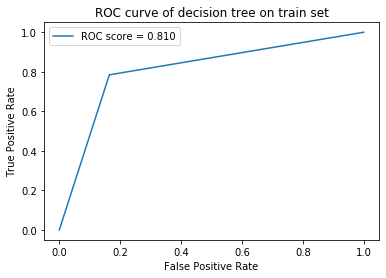

In [671]:
# Plot the ROC curves
from sklearn.metrics import roc_curve
from matplotlib import pyplot

# Calculate roc curve of original decision tree on train set
ns_fpr1, ns_tpr1, _ = roc_curve(y, y_pred_dt)
# Plot the roc curve for the model
pyplot.plot(ns_fpr1, ns_tpr1)
# Axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# Show the legend
pyplot.legend(['ROC score = 0.810'])
# Show the title
pyplot.title('ROC curve of decision tree on train set')
# Show the plot
pyplot.show()

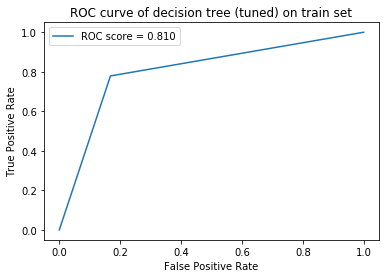

In [672]:
# Calculate roc curve of decision tree on train set after hyperparameter tuning
ns_fpr, ns_tpr, _ = roc_curve(y, y_pred_dt_ht)
# Plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr)
# Axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# Show the legend
pyplot.legend(['ROC score = 0.810'])
# Show the title
pyplot.title('ROC curve of decision tree (tuned) on train set')
# Show the plot
pyplot.show()

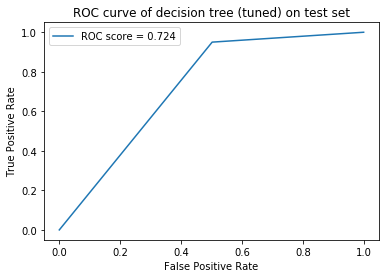

In [673]:
# Calculate roc curve of decision tree (tuned) on test set
ns_fpr, ns_tpr, _ = roc_curve(y_test, y_pred_dttest)
# Plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr)
# Axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# Show the legend
pyplot.legend(['ROC score = 0.724'])
# Show the title
pyplot.title('ROC curve of decision tree (tuned) on test set')
# Show the plot
pyplot.show()

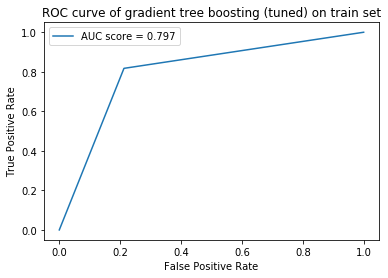

In [674]:
# Calculate roc curve of gradient tree boosting after hyperparameter tuning on train set
ns_fpr, ns_tpr, _ = roc_curve(y, y_pred_gb2)
# Plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr)
# Axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# Show the legend
pyplot.legend(['AUC score = 0.797'])
# Show the title
pyplot.title('ROC curve of gradient tree boosting (tuned) on train set')
# Show the plot
pyplot.show()

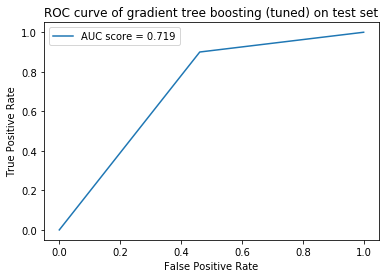

In [675]:
# Calculate roc curve of gradient tree boosting (tuned) on test set
ns_fpr, ns_tpr, _ = roc_curve(y_test, y_pred_gb3)
# Plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr)
# Axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# Show the legend
pyplot.legend(['AUC score = 0.719'])
# Show the title
pyplot.title('ROC curve of gradient tree boosting (tuned) on test set')
# Show the plot
pyplot.show()

'EC2.pdf'

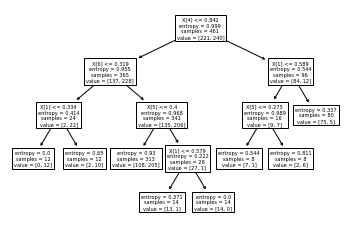

In [700]:
# Plot the decision tree on test set
from sklearn import tree

dt_test = tree.DecisionTreeClassifier(criterion ='entropy', splitter = 'random', max_leaf_nodes = 350, 
                                      min_samples_leaf = 5, min_samples_split = 3, max_features = 'auto', random_state = 10)
dt_test = dt_test.fit(X_test, y_test)
tree.plot_tree(dt_test) 

# Export the decision tree as pdf file
import graphviz 
spot_features = ['vcpus', 'sustained_clock_speed_ghz', 'memory_mib','gpus', 'on_demand_hibernation_support', 'burstable_performance_support', 'current_generation']
y_labels.fit_transform(spot_test.interruption_rate)
dot_data = tree.export_graphviz(dt_test, out_file=None, feature_names = spot_features, class_names= ['unlikely','likely'], filled=True,rounded=True,special_characters=True) 
graph = graphviz.Source(dot_data) 
graph.render("EC2")